In [1]:
import pandas as pd
import csv
from datetime import datetime
import time
import os
import numpy as np
import string
import random

In [2]:
def generate_entry():
    """"""
    n = random.randint(3, 25)
    m = random.randint(1,n-1)
    # ensuring that each entry is mix of numeric and non-numeric
    entry= [random.choice(string.ascii_letters) for i in range(m)]+[random.choice(string.digits) for i in range(n-m)]
    return ''.join(entry)

In [3]:
def create_csv(csv_file_name, size, mst, cols=10):
    fields = ['Col'+str(i+1) for i in range(cols)]
    with open(csv_file_name, 'w') as csvfile:
        write = csv.writer(csvfile)
        wt = 0 # write time
        ct = 0 # creation time
        lt = 0 # load time: time taken to load data after creating fake data
        tw1 = time.time()
        write.writerow(fields)
        tw2 = time.time()
        wt += (tw2-tw1)
        pre_row = None
        while (os.path.getsize(csv_file_name)) < size:
            tc1 = time.time()
            row = [generate_entry() for x in range(cols)]
            tc2 = time.time()
            ct += (tc2-tc1)
            
            tl1 = time.time()
            if pre_row is None:
                tw1 = time.time()
                write.writerows([row])
                tw2 = time.time()
                pre_row = row
            else:
                if pre_row != row:
                    tw1 = time.time()
                    write.writerows([row])
                    tw2 = time.time()
                    pre_row = row
            tl2 = time.time()
            wt += (tw2-tw1)
            lt += (tl2 - tl1)
    print("Execution time for creating "+csv_file_name.split("/")[-1]+":%f seconds"%(ct))
    return {"file_size":size, "write_time":wt, "measurement":mst, "creation_time":ct, "load_time":lt-wt}

In [4]:
s = 1024*1024
file_size = [0.1*s, 1*s, 5*s, 10*s, 100*s, 500*s]
# file_size = [0.1*s, 1*s, 5*s]
results_w = {}
for size in file_size:
    for mst in range(3):
        fname = "data/{name}_m{mst}_{size}MB.csv".format(name=str(time.time()).replace(".",""), mst=mst+1, size=size/s)
        results_w[fname.split("/")[-1]] = create_csv(fname, size, mst+1)

Execution time for creating 1619342002268544_m1_0.1MB.csv:0.098666 seconds
Execution time for creating 16193420023754802_m2_0.1MB.csv:0.090327 seconds
Execution time for creating 1619342002473378_m3_0.1MB.csv:0.089946 seconds
Execution time for creating 1619342002569588_m1_1.0MB.csv:0.885000 seconds
Execution time for creating 16193420035145931_m2_1.0MB.csv:0.887582 seconds
Execution time for creating 1619342004461786_m3_1.0MB.csv:0.893382 seconds
Execution time for creating 1619342005417301_m1_5.0MB.csv:4.410805 seconds
Execution time for creating 16193420101190841_m2_5.0MB.csv:4.309189 seconds
Execution time for creating 1619342014755585_m3_5.0MB.csv:4.327065 seconds
Execution time for creating 1619342019355065_m1_10.0MB.csv:8.708216 seconds
Execution time for creating 16193420286436522_m2_10.0MB.csv:8.556598 seconds
Execution time for creating 1619342037721733_m3_10.0MB.csv:8.686116 seconds
Execution time for creating 1619342047144616_m1_100.0MB.csv:84.935403 seconds
Execution time 

In [5]:
results_r = {}
# load data into pandas dataframe
for fname in results_w:
    tr1 = time.time()
    df = pd.read_csv("data/"+fname)
    tr2 = time.time()
    rt = tr2 - tr1
    results_r[fname] = {"read_time":rt}

Results: table of values (file size versus read time and write time for each experiment) 

In [6]:
file_size = []
read_time = []
write_time = []
load_time = []
for fname in results_w:
    file_size.append(results_w[fname]["file_size"]/s)
    write_time.append(results_w[fname]["write_time"])
    load_time.append(results_w[fname]["load_time"])
    read_time.append(results_r[fname]["read_time"])
df = pd.DataFrame({"file_size":file_size,"read_time":read_time,"write_time":write_time, "load_time":load_time})
                  

In [7]:
print(df[["file_size","read_time","write_time"]].to_string(index=False))

 file_size  read_time  write_time
       0.1   0.032151    0.003439
       0.1   0.006647    0.003047
       0.1   0.005986    0.002982
       1.0   0.032130    0.029599
       1.0   0.032601    0.030006
       1.0   0.033484    0.031076
       5.0   0.152688    0.143865
       5.0   0.173028    0.194930
       5.0   0.153687    0.137892
      10.0   0.337986    0.310252
      10.0   0.344522    0.266296
      10.0   0.349802    0.468746
     100.0   3.175637    2.755244
     100.0   3.272399    2.740806
     100.0   3.197883    2.827125
     500.0  19.411626   13.462223
     500.0  28.892956   13.555547
     500.0  28.475812   14.146447


In [8]:
df_p = pd.DataFrame({"write_time":df.groupby(["file_size"]).write_time.mean().values,
                    "load_time":df.groupby(["file_size"]).load_time.mean().values},
                   index=[df.file_size.unique()])

Text(0, 0.5, 'average time')

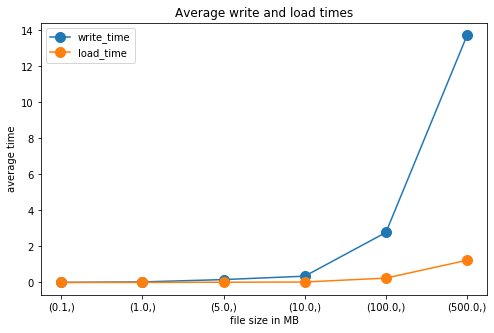

In [9]:
ax = df_p.plot.line(title="Average write and load times", marker='o', markersize=10, figsize=(8,5))
ax.set_xlabel("file size in MB")
ax.set_ylabel("average time")